In [24]:
import numpy as np
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from transformers import ViTForImageClassification
from torch.optim.lr_scheduler import StepLR
from tqdm import trange
from sklearn.model_selection import train_test_split
import torchvision.datasets as datasets
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torchvision.models as models
sns.set()

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [3]:
os.listdir('/kaggle/input/')

['flower_images']

In [4]:
os.listdir('/kaggle/input/flower_images')

['Orchid', 'Sunflower', 'Tulip', 'Lotus', 'Lilly']

In [5]:
dataset_dir = '/kaggle/input/flower_images'

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

In [7]:
dataset = datasets.ImageFolder(root = dataset_dir, transform = transform)

In [8]:
targets = np.array([label for _, label in dataset])

In [9]:
train_idx, temp_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    stratify=targets,
    random_state=42
)

In [10]:
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.33,
    stratify=targets[temp_idx],
    random_state=42
)

In [11]:
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

In [12]:
print(f'Size of training set: {len(train_dataset)}')
print(f'Size of test set: {len(test_dataset)}')
print(f'Size of validation set: {len(val_dataset)}')

Size of training set: 3499
Size of test set: 495
Size of validation set: 1005


In [13]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False, num_workers = 4)

In [14]:
num_classes = len(dataset.classes)
print(f'Number of classes in the dataset: {num_classes}')

Number of classes in the dataset: 5


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [16]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels = num_classes
).to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
for name, param in model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = True
    elif 'encoder.layer' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [18]:
optimizer = torch.optim.AdamW([
    {'params': [p for n, p in model.named_parameters() if 'classifier' in n], 'lr': 1e-4},
    {'params': [p for n, p in model.named_parameters() if 'encoder' in n], 'lr': 3e-5}
], weight_decay = 0.01)

In [19]:
scheduler = StepLR(optimizer, step_size = 3, gamma = 0.1)

In [16]:
def plot_results(train_accs, train_losses, val_accs, val_losses):
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    xs = np.arange(1, len(train_accs) + 1, 1)
    axes[0].plot(xs, train_accs, label = 'Training')
    axes[0].plot(xs, val_accs, label = 'Validation')
    axes[0].set_title('Training accuracy vs Validation accuracy', fontsize = 15)
    axes[0].set_xlabel('Epoch', fontsize = 10)
    axes[0].set_ylabel('Accuracy', fontsize = 10)
    axes[0].set_xticks(xs)
    axes[0].legend()
    axes[1].plot(xs, train_losses, label = 'Training')
    axes[1].plot(xs, val_losses, label = 'Validation')
    axes[1].set_title('Training loss vs Validation loss', fontsize = 15)
    axes[1].set_xlabel('Epoch', fontsize = 10)
    axes[1].set_ylabel('Loss', fontsize = 10)
    axes[1].set_xticks(xs)
    axes[1].legend()
    plt.tight_layout()
    plt.show()

In [21]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    model.train()
    total_acc = 0
    total_loss = 0
    for batch in dataloader:
        images, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        preds = model(images).logits
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += (preds.argmax(dim=1) == labels).sum().item()
    return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [22]:
def val_step(model, criterion, dataloader, device = device):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            preds = model(images).logits
            total_loss += criterion(preds, labels).item()
            total_acc += (preds.argmax(dim=1) == labels).sum().item()
    return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [23]:
def train_model(model, n_epochs, optimizer, train_loader, val_loader, device = device):
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    criterion = torch.nn.CrossEntropyLoss()
    pbar = trange(n_epochs)
    for epoch in pbar:
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        val_loss, val_acc = val_step(model, criterion, val_loader, device)
        scheduler.step()
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        pbar.set_description(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f} | Valid Loss: {val_loss:.3f} | Valid Acc: {val_acc:.3f}')
    plot_results(train_accs, train_losses, val_accs, val_losses)
    return {'train_acc': train_acc, 'train_loss': train_loss, 'val_acc': val_acc, 'val_loss': val_loss}

Train Loss: 0.021 | Train Acc: 99.714 | Valid Loss: 0.085 | Valid Acc: 97.711: 100%|██████████| 10/10 [12:31<00:00, 75.17s/it]


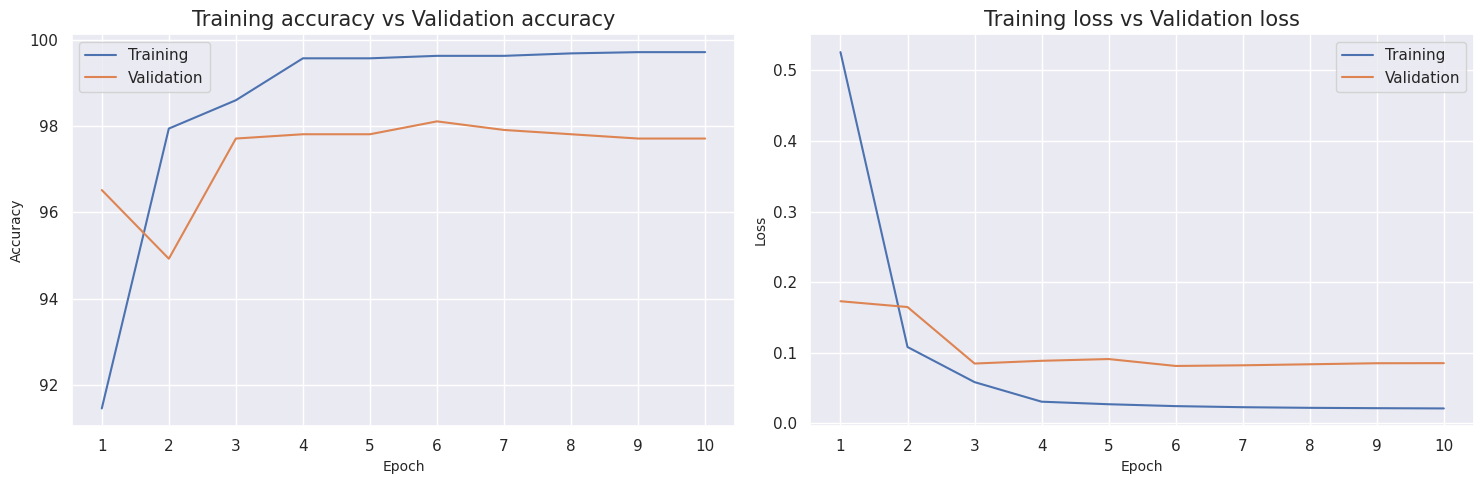

In [24]:
results = train_model(model, 10, optimizer, train_loader, val_loader, device)

In [17]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    model.train()
    total_loss = 0
    total_acc = 0
    for batch in dataloader:
        images, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += (preds.argmax(dim=1) == labels).sum().item()
    return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [18]:
def val_step(model, criterion, dataloader, device = device):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            preds = model(images)
            total_loss += criterion(preds, labels).item()
            total_acc += (preds.argmax(dim=1) == labels).sum().item()
    return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [19]:
def train_model(model, n_epochs, optimizer, train_loader, val_loader, device = device):
    train_accs, train_losses, val_accs, val_losses = [], [], [], []
    criterion = nn.CrossEntropyLoss()
    pbar = trange(n_epochs)
    for epoch in pbar:
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        val_loss, val_acc = val_step(model, criterion, val_loader, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        pbar.set_description(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f} | Validation Loss: {val_loss:.3f} | Validation Acc: {val_acc:.3f}')
    plot_results(train_accs, train_losses, val_accs, val_losses)
    return {'train_acc': train_acc, 'train_loss': train_loss, 'val_acc': val_acc, 'val_loss': val_loss}

In [20]:
class conv_model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(conv_model, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.240 | Train Acc: 90.883 | Validation Loss: 1.259 | Validation Acc: 70.050: 100%|██████████| 10/10 [06:59<00:00, 41.96s/it]


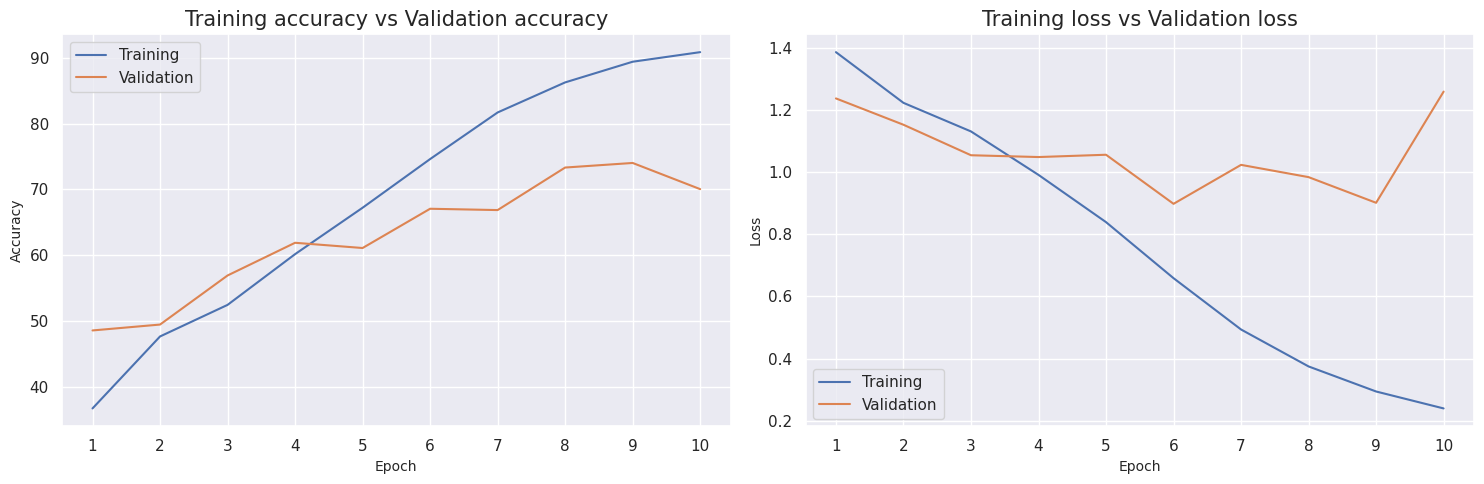

In [40]:
model2 = conv_model(224 * 224 * 3, num_classes).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.001)
results = train_model(model2, 10, optimizer, train_loader, val_loader, device = device)

In [41]:
class conv_model2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(conv_model2, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.258 | Train Acc: 91.312 | Validation Loss: 0.733 | Validation Acc: 77.811: 100%|██████████| 10/10 [08:11<00:00, 49.12s/it]


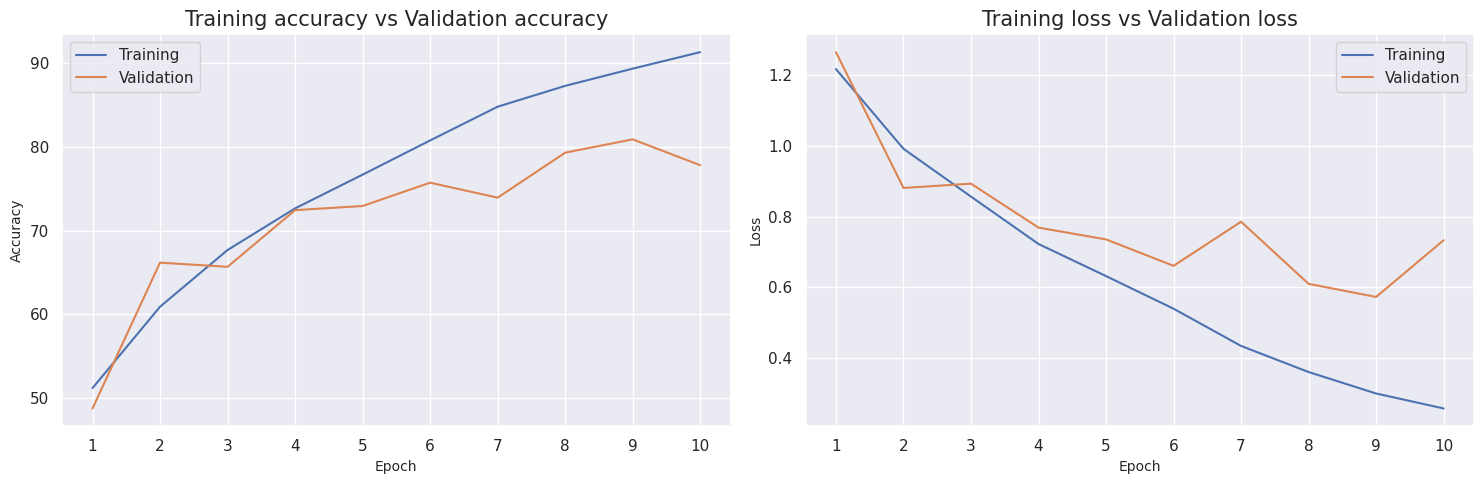

In [43]:
model2 = conv_model2(224 * 224 * 3, num_classes).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.001)
results = train_model(model2, 10, optimizer, train_loader, val_loader, device)

In [20]:
class conv_model3(nn.Module):
    def __init__(self, input_size, num_classes):
        super(conv_model3, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.416 | Train Acc: 84.853 | Validation Loss: 0.703 | Validation Acc: 77.612: 100%|██████████| 10/10 [11:07<00:00, 66.79s/it]


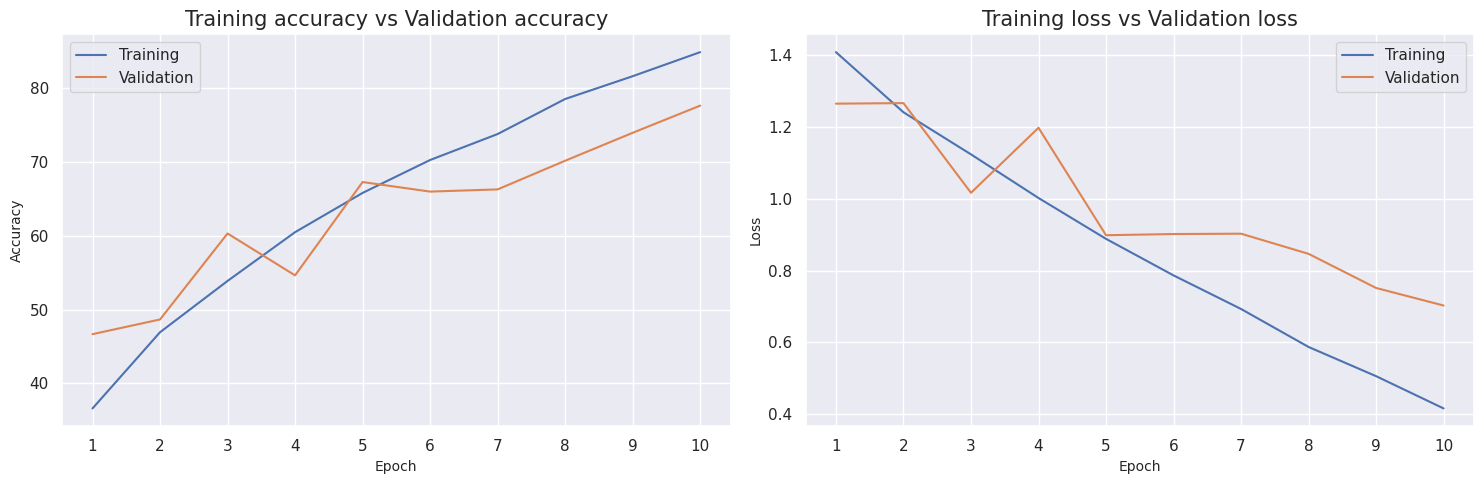

In [21]:
model3 = conv_model3(224 * 224 * 3, num_classes).to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr = 0.001)
results = train_model(model3, 10, optimizer, train_loader, val_loader, device)

In [22]:
class conv_model4(nn.Module):
    def __init__(self, input_size, num_classes):
        super(conv_model4, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.520 | Train Acc: 81.938 | Validation Loss: 0.672 | Validation Acc: 77.313: 100%|██████████| 10/10 [15:04<00:00, 90.44s/it]


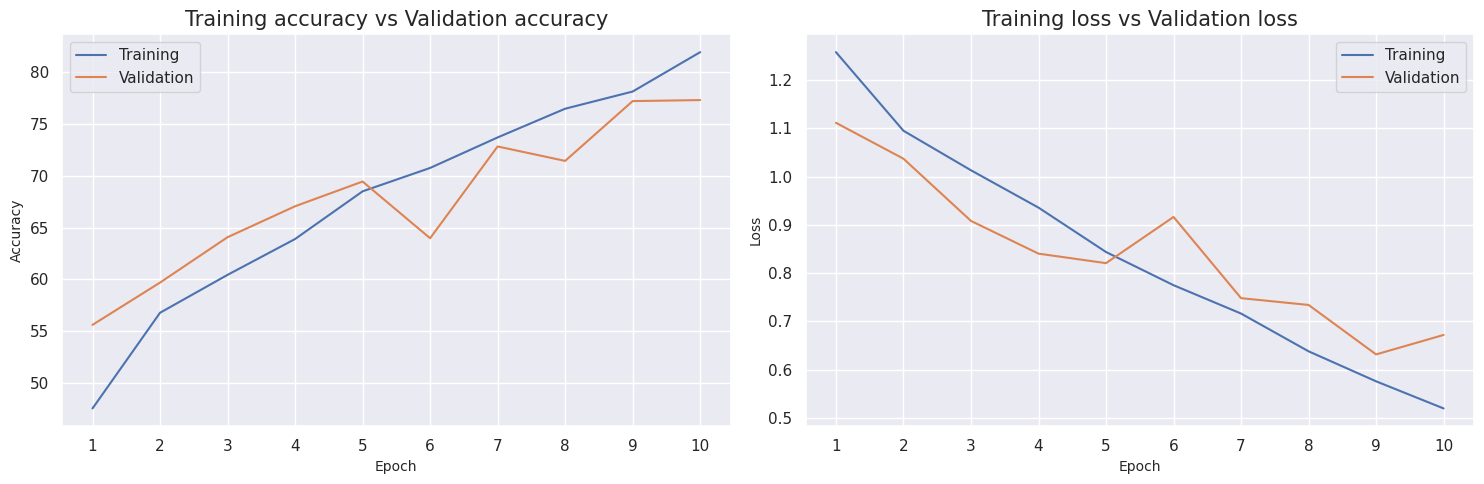

In [23]:
model4 = conv_model4(224 * 224* 3, num_classes).to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr = 0.001)
results = train_model(model4, 10, optimizer, train_loader, val_loader, device)

In [25]:
resnet50 = models.resnet50(pretrained = True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


In [26]:
num_ftrs = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_ftrs, num_classes)

In [27]:
resnet50 = resnet50.to(device)

Train Loss: 0.197 | Train Acc: 93.027 | Validation Loss: 0.392 | Validation Acc: 89.154: 100%|██████████| 10/10 [07:24<00:00, 44.50s/it]


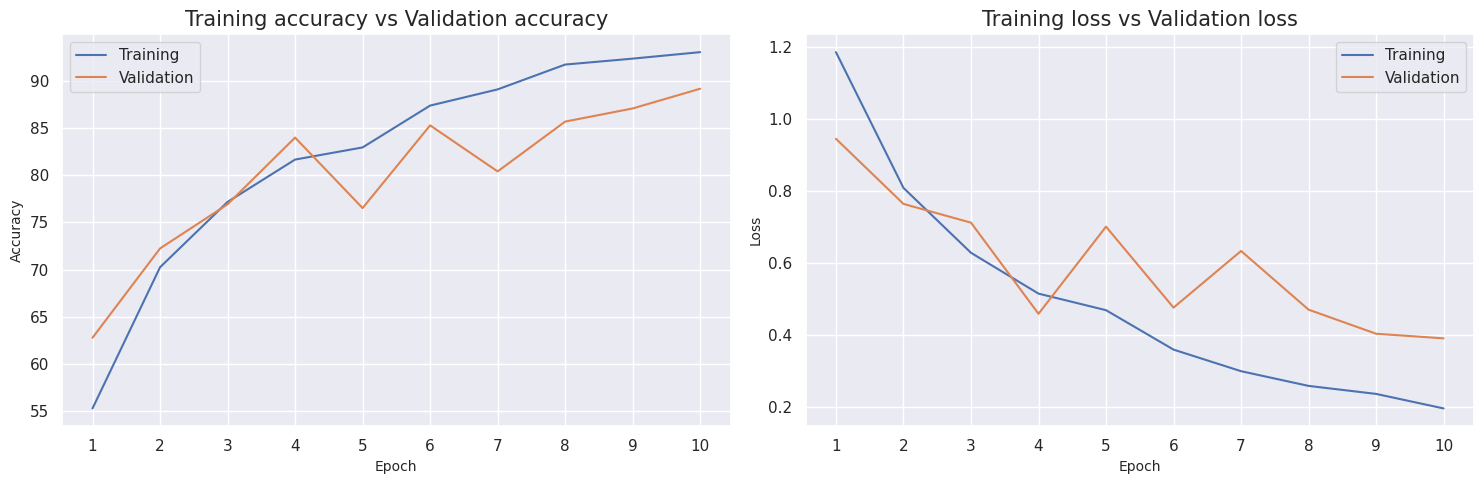

In [28]:
optimizer = torch.optim.Adam(resnet50.parameters(), lr = 0.001)
results = train_model(resnet50, 10, optimizer, train_loader, val_loader, device)